In [10]:
import os, random
import numpy as np
import matplotlib.image as pltimage
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import torch, torchvision

def show_files(label_dir):
    all_files = []
    file_list = os.listdir(label_dir)
    for file in file_list:
        cur_path = os.path.join(label_dir, file)
        root, extension = os.path.splitext(cur_path)
        ext_lower = extension.lower()
        if ext_lower == ".png" or ext_lower == ".jpg" or ext_lower == ".jpeg":
            all_files.append(cur_path)
    return all_files

def obtainXY(data_dir, augmented=False, shuffle=False):
    X = []
    Y = []
    classes =  [i for i in range(10)]
    all_file_count = 0
    for label in classes:
        all_files = show_files(data_dir + str(label))
        all_file_count += len(all_files)
        for file in all_files:
            org = Image.open(file)
            # 需要数据增广
            w, h, c = (*org.size, len(org.mode))
            # 数据增广配置
            trans = torchvision.transforms.Compose([
                torchvision.transforms.RandomAffine(translate=(0.25, 0.25), scale=(0.8, 1.2), degrees=40, interpolation=torchvision.transforms.functional.InterpolationMode.NEAREST),
                torchvision.transforms.RandomHorizontalFlip(p=0.2),
                torchvision.transforms.RandomCrop(size=(h, w))])
            # 增广15倍，带原图16张
            for i in range(16):
                if i == 0:
                    img = org
                else:
                    img = trans(org)
                img = img.resize((28, 28), Image.ANTIALIAS)
                gray = img.convert("L")
                x = np.asarray(gray)/255.
                y = label
                X.append(x)
                Y.append(y)
                if not augmented: # 不需要增广时，只用原图
                    break
    print("all file count=", all_file_count)
    X = np.array(X)
    Y = np.array(Y)
    if shuffle:
        indexs = [i for i in range(len(X))] 
        random.shuffle(indexs) #乱序
        X = X[indexs]
        Y = Y[indexs]
    return X, Y

dataset_dir = "./dataset/"
X, Y = obtainXY(dataset_dir, augmented=True, shuffle=True)
print("train data:", X.shape, Y.shape)

train_x = X
# 将label转成向量，如 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
train_y = tf.keras.utils.to_categorical(Y, num_classes=10)
# input output shape
print("tran data shape:", train_x.shape, train_y.shape)

dataset_test_dir = "./dataset-test/"
vX, vY = obtainXY(dataset_test_dir)
print("test data:", vX.shape, vY.shape)

all file count= 2098
train data: (33568, 28, 28) (33568,)
tran data shape: (33568, 28, 28) (33568, 10)
all file count= 207
test data: (207, 28, 28) (207,)


In [11]:
from collections import Counter

def print_pecent(data, class_num=10):
    y_ = list(data)
    size = len(y_)
    class_counter = Counter(y_)
    print(class_counter, size)
    for i in range(class_num):
        print(i, "占比:", round(class_counter[i]/size, 3))

print_pecent(Y)

Counter({7: 3648, 6: 3472, 9: 3472, 5: 3456, 4: 3424, 3: 3376, 0: 3312, 1: 3232, 8: 3216, 2: 2960}) 33568
0 占比: 0.099
1 占比: 0.096
2 占比: 0.088
3 占比: 0.101
4 占比: 0.102
5 占比: 0.103
6 占比: 0.103
7 占比: 0.109
8 占比: 0.096
9 占比: 0.103


In [12]:
from keras import layers, regularizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# 全连接网络
def creat_nn(print_summary=False):
    model = Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model

# 卷积神经网络
def creat_cnn(print_summary=False):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model

# 训练模型
def train_net(train_x, train_y, batch_size, epochs, use_cnn=False, load_save_model=False):
    if use_cnn:
        tflite_name = "mymodel-cnn.tflite"
        model_path = './model-cnn/'
    else:
        tflite_name = "mymodel.tflite"
        model_path = './model/'
    if load_save_model:
        print('train load save model path', model_path)
        model = load_model(model_path)
    else:
        print('train create new model')
        if use_cnn:
            model = creat_cnn(print_summary=True) # cnn卷积神经网络
        else:
            model = creat_nn(print_summary=True) # 全连接网络
    model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1)
    model.save(model_path)
    
    #save tflite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open(tflite_name, "wb").write(tflite_model)
    return model

# 验证模型
def verify_model(model, valid_x, valid_y, num_classes=10):
    y_pred = model.predict(valid_x)
    y_pred = np.argmax(y_pred, axis=1)
    size = [0 for i in range(num_classes)]
    correct = [0 for i in range(num_classes)]
    for i in range(len(y_pred)):
        label = valid_y[i]
        pred = y_pred[i]
        size[label] += 1
        if pred == label:
            correct[label] += 1
    print("total accuracy:", sum(correct)/sum(size))
    for i in range(num_classes):
        print("label:", str(i), " accuracy:", correct[i]/max(size[i], 1))

In [13]:
# 训练全连接网络模型
model = train_net(train_x, train_y, batch_size=16, epochs=24, load_save_model=False)
verify_model(model, vX, vY)

train create new model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/24
2098/2098 [==============================] - 3s 1ms/step - loss: 1.8426 - accuracy: 0.3574
Epoch 2/24
2098/2098 [==============================] -

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmp8ekk6u17/assets


INFO:tensorflow:Assets written to: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmp8ekk6u17/assets


7/7 [==============================] - 0s 1ms/step
total accuracy: 0.9082125603864735
label: 0  accuracy: 0.7727272727272727
label: 1  accuracy: 0.96
label: 2  accuracy: 0.9166666666666666
label: 3  accuracy: 0.7894736842105263
label: 4  accuracy: 0.9545454545454546
label: 5  accuracy: 0.8333333333333334
label: 6  accuracy: 1.0
label: 7  accuracy: 1.0
label: 8  accuracy: 0.9
label: 9  accuracy: 1.0


2022-07-10 00:45:01.151734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-10 00:45:01.151755: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-07-10 00:45:01.151906: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmp8ekk6u17
2022-07-10 00:45:01.153995: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-07-10 00:45:01.154019: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmp8ekk6u17
2022-07-10 00:45:01.160399: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-10 00:45:01.216055: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmp8ekk6u17
2022-07-

In [14]:
# 训练CNN卷积神经网络模型
model = train_net(train_x, train_y, batch_size=16, epochs=16, use_cnn=True, load_save_model=False)
verify_model(model, vX, vY)

train create new model
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 16)          4624      
                                                                 
 flatten_4 (Flatten)         (None, 576)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                18464     
                                                                 
 dense_9 (Dense)             (None, 10)                330       
                                                                 
Total params: 23,738
Trainable params: 23,738
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
2098/2098 [=====

INFO:tensorflow:Assets written to: ./model-cnn/assets


INFO:tensorflow:Assets written to: ./model-cnn/assets


INFO:tensorflow:Assets written to: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmpspnn9te9/assets


INFO:tensorflow:Assets written to: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmpspnn9te9/assets


7/7 [==============================] - 0s 3ms/step
total accuracy: 0.966183574879227
label: 0  accuracy: 0.9545454545454546
label: 1  accuracy: 0.92
label: 2  accuracy: 1.0
label: 3  accuracy: 1.0
label: 4  accuracy: 1.0
label: 5  accuracy: 0.9166666666666666
label: 6  accuracy: 1.0
label: 7  accuracy: 1.0
label: 8  accuracy: 1.0
label: 9  accuracy: 0.8333333333333334


2022-07-10 00:48:15.445869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-10 00:48:15.445917: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-07-10 00:48:15.446077: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmpspnn9te9
2022-07-10 00:48:15.448569: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-07-10 00:48:15.448592: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmpspnn9te9
2022-07-10 00:48:15.459114: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-10 00:48:15.545525: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/yn/ntp3qk1946g09h3hckj58phm0000gp/T/tmpspnn9te9
2022-07-

In [15]:
# retrain model
#train_net(train_x, train_y, batch_size=16, epochs=8, load_save_model=True)

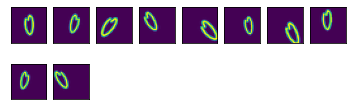

In [16]:
# 数据增广测试代码，第一张为原图，其他为变换后图片
import torch
import torchvision
org = Image.open("./dataset/0/2022_06_28_08_27_39_796.png")
w, h, c = (*org.size, len(org.mode))
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(translate=(0.25, 0.25), scale=(0.8, 1.2), degrees=40, interpolation=torchvision.transforms.functional.InterpolationMode.NEAREST),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.RandomCrop(size=(h, w))])

plt.figure()
for i in range(10):
    if i == 0:
        img = org
    else:
        img = trans(org)
    img = img.resize((28, 28), Image.ANTIALIAS)
    gray = img.convert("L")
    plt.subplot(4, 8, i+1)
    plt.imshow(gray)
    plt.xticks([])
    plt.yticks([])
plt.show()